In [ ]:
#Mount the google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# direct to the folder where the data located, change the folder path here if needed
%cd '/content/drive/MyDrive/CSCE 638 NLP Project/LOL_Data/' 
!ls

/content/drive/MyDrive/CSCE 638 NLP Project/LOL_Data
dev1000.csv  model_plot.png  Results  test1000.csv  train8000.csv


In [ ]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import GroupKFold
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# import tensorflow_hub as hub
import tensorflow as tf
# import bert_tokenization as tokenization
import tensorflow.keras.backend as K
from tensorflow import keras 

import os
from scipy.stats import spearmanr
from math import floor, ceil
!pip install transformers
!pip install sentencepiece
from transformers import *

import seaborn as sns
import string
import re    #for regex

np.set_printoptions(suppress=True)
print(tf.__version__)

     |████████████████████████████████| 2.1MB 14.7MB/s 
     |████████████████████████████████| 870kB 51.3MB/s 
     |████████████████████████████████| 3.3MB 55.0MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=6de27786a8ed845e3eafbc94121addedc8a7fd3fc662bf2dbb837ad517fe18d5
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f448366744654323077c4d90069b6512f3c
Successfully built sacremoses
     |████████████████████████████████| 1.2MB 15.5MB/s 
2.4.1


# Prep / tokenizer

#### 1. Read data and tokenizer

Read tokenizer and data, as well as defining the maximum sequence length that will be used for the input to Bert (maximum is usually 512 tokens)

In [ ]:
training_sample_count = 8000
dev_count = 1000
test_count = 1000

running_folds = 1

MAX_SENTENCE_LENGTH = 20 # max number of words in a sentence
MAX_SENTENCES = 5 # max number of sentences to encode in a text

MAX_LENGTH = 100 # max words in a text as whole sentences

In [ ]:
df_train = pd.read_csv('train8000.csv')
df_train = df_train[:training_sample_count*running_folds]
#df_train = df_train[df_train['is_humor']==1]
print(df_train.describe())
display(df_train.head())

df_dev = pd.read_csv('dev1000.csv')
df_dev = df_dev[:dev_count*running_folds]
#df_dev = df_dev[df_dev['is_humor']==1]
print(df_dev.describe())

df_test = pd.read_csv('test1000.csv')
df_test = df_test[:test_count]
display(df_test.head(3))

               id     is_humor  humor_rating  humor_controversy  offense_rating
count  8000.00000  8000.000000   4932.000000        4932.000000     8000.000000
mean   4000.50000     0.616500      2.260525           0.499797        0.585325
std    2309.54541     0.486269      0.566974           0.500051        0.979955
min       1.00000     0.000000      0.100000           0.000000        0.000000
25%    2000.75000     0.000000      1.890000           0.000000        0.000000
50%    4000.50000     1.000000      2.280000           0.000000        0.100000
75%    6000.25000     1.000000      2.650000           1.000000        0.700000
max    8000.00000     1.000000      4.000000           1.000000        4.850000


,id,text,is_humor,humor_rating,humor_controversy,offense_rating
0,1,TENNESSEE: We're the best state. Nobody even c...,1,2.42,1.0,0.2
1,2,A man inserted an advertisement in the classif...,1,2.50,1.0,1.1
2,3,How many men does it take to open a can of bee...,1,1.95,0.0,2.4
3,4,Told my mom I hit 1200 Twitter followers. She ...,1,2.11,1.0,0.0
4,5,Roses are dead. Love is fake. Weddings are bas...,1,2.78,0.0,0.1


                id     is_humor  ...  humor_controversy  offense_rating
count  1000.000000  1000.000000  ...         632.000000     1000.000000
mean   8500.500000     0.632000  ...           0.487342        0.706250
std     288.819436     0.482503  ...           0.500236        1.190635
min    8001.000000     0.000000  ...           0.000000        0.000000
25%    8250.750000     0.000000  ...           0.000000        0.000000
50%    8500.500000     1.000000  ...           0.000000        0.100000
75%    8750.250000     1.000000  ...           1.000000        0.812500
max    9000.000000     1.000000  ...           1.000000        4.700000

[8 rows x 5 columns]


,id,text
0,9001,Finding out your ex got fat is like finding 20...
1,9002,"For Brockmann, stereotypes imperil national se..."
2,9003,A girl runs up to her mother with a pile of cr...


In [ ]:
output_categories = list(df_train.columns[[5]]) # offense rating
input_categories = list(df_train.columns[[1]]) # text

TARGET_COUNT = len(output_categories)

print('\ninput categories:\n\t', input_categories)
print('\noutput categories:\n\t', output_categories)
print('\noutput TARGET_COUNT:\n\t', TARGET_COUNT)


input categories:
	 ['text']

output categories:
	 ['offense_rating']

output TARGET_COUNT:
	 1


## 2. Preprocessing functions

These are some functions that will be used to preprocess the raw text data into useable Bert inputs.<br>


In [ ]:
from transformers import BertTokenizer

MODEL_TYPE = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(MODEL_TYPE)

import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
def return_id(str1, str2, truncation_strategy, length):

    inputs = tokenizer.encode_plus(str1, str2,
        add_special_tokens=True,
        max_length=length,
        truncation_strategy=truncation_strategy)

    input_ids =  inputs["input_ids"] #token indices, numerical representations of tokens building the sequences that will be used as input by the model
    input_masks = [1] * len(input_ids) # indicate the ids should be attended
    input_segments = inputs["token_type_ids"] #BERT, also deploy token type IDs (also called segment IDs). They are represented as a binary mask identifying the two types of sequence in the model.

    padding_length = length - len(input_ids)
    padding_id = tokenizer.pad_token_id

    input_ids = input_ids + ([padding_id] * padding_length)
    input_masks = input_masks + ([0] * padding_length)
    input_segments = input_segments + ([0] * padding_length)

    return [input_ids, input_masks, input_segments]


def compute_input_arrays(df, columns, tokenizer):

    model_input = []
    for xx in range((MAX_SENTENCES*3)+3): # +3 for the whole sentences
        model_input.append([])
    
    for _, row in tqdm(df[columns].iterrows()):
        #print(type(row))
        #print(row)
        #print(row.text)
        #print(type(row.text))
        #stop

        i = 0
        
        # sent
        sentences = sent_tokenize(row.text) # separate a long text into sentences

        for xx in range(MAX_SENTENCES): # MAX_SENTENCES = 5

            s = sentences[xx] if xx<len(sentences) else ''

            ids_q, masks_q, segments_q = return_id(s, None, 'longest_first', MAX_SENTENCE_LENGTH) #MAX_SENTENCE_LENGTH = 20

            model_input[i].append(ids_q)
            i+=1
            model_input[i].append(masks_q)
            i+=1
            model_input[i].append(segments_q)
            i+=1
        
        # full row
        ids_q, masks_q, segments_q = return_id(row.text, None, 'longest_first', MAX_LENGTH) # MAX_LENGTH = 100

        model_input[i].append(ids_q)
        i+=1
        model_input[i].append(masks_q)
        i+=1
        model_input[i].append(segments_q)
        
    for xx in range((MAX_SENTENCES*3)+3):
        model_input[xx] = np.asarray(model_input[xx], dtype=np.int32)
        
    print(model_input[0].shape)

    return model_input

inputs      = compute_input_arrays(df_train, input_categories, tokenizer)
dev_inputs = compute_input_arrays(df_dev, input_categories, tokenizer)
test_inputs = compute_input_arrays(df_test, input_categories, tokenizer)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.



(8000, 20)



(1000, 20)



(1000, 20)


In [ ]:
# check the tokenized sentences
print(len(inputs), len(inputs[0]), len(inputs[0][0]))

# check out input for 7th row
xx = 7
print(df_train.iloc[xx,1])
print(sent_tokenize(df_train.iloc[xx,1]))
inputs[0][xx], inputs[3][xx], inputs[6][xx], inputs[15][xx]

18 8000 20
ME: I'm such an original. Truly one of a kind. ALSO ME: [holding a glass of white wine] I love to laugh.
["ME: I'm such an original.", 'Truly one of a kind.', 'ALSO ME: [holding a glass of white wine] I love to laugh.']


(array([ 101, 2033, 1024, 1045, 1005, 1049, 2107, 2019, 2434, 1012,  102,
           0,    0,    0,    0,    0,    0,    0,    0,    0], dtype=int32),
 array([ 101, 5621, 2028, 1997, 1037, 2785, 1012,  102,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0], dtype=int32),
 array([ 101, 2036, 2033, 1024, 1031, 3173, 1037, 3221, 1997, 2317, 4511,
        1033, 1045, 2293, 2000, 4756, 1012,  102,    0,    0], dtype=int32),
 array([ 101, 2033, 1024, 1045, 1005, 1049, 2107, 2019, 2434, 1012, 5621,
        2028, 1997, 1037, 2785, 1012, 2036, 2033, 1024, 1031, 3173, 1037,
        3221, 1997, 2317, 4511, 1033, 1045, 2293, 2000, 4756, 1012,  102,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    

In [ ]:
def compute_output_arrays(df, columns):
    return np.asarray(df[columns])

outputs = compute_output_arrays(df_train, output_categories)
dev_outputs = compute_output_arrays(df_dev, output_categories)

## 3. Create model



In [ ]:
config = BertConfig() # print(config) to see settings
config.output_hidden_states = False # Set to True to obtain hidden states
bert_model = TFBertModel.from_pretrained('bert-base-uncased', config=config)
config

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


BertConfig {
  "_name_or_path": "bert-base-uncased",
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.5.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [ ]:
def create_model():
    # model structure
    # takes q_ids [max=20*MAX_SENTENCES] and a_ids [max=200]
    import gc
    
    model_inputs = []
    f_inputs=[]

    for i in range(MAX_SENTENCES):
        
        # bert embeddings
        q_id = tf.keras.layers.Input((MAX_SENTENCE_LENGTH,), dtype=tf.int32)
        q_mask = tf.keras.layers.Input((MAX_SENTENCE_LENGTH,), dtype=tf.int32)
        q_atn = tf.keras.layers.Input((MAX_SENTENCE_LENGTH,), dtype=tf.int32)
        q_embedding = bert_model(q_id, attention_mask=q_mask, token_type_ids=q_atn)[0]
        q = tf.keras.layers.GlobalAveragePooling1D()(q_embedding)
        
        # internal model
        hidden1 = keras.layers.Dense(32, activation="relu")(q)
        hidden2 = keras.layers.Dropout(0.3)(hidden1)
        hidden3 = keras.layers.Dense(8, activation='relu')(hidden2)
        
        f_inputs.append(hidden3)
        model_inputs.extend([q_id, q_mask, q_atn])
        
    # whole sentence
    a_id = tf.keras.layers.Input((MAX_LENGTH,), dtype=tf.int32)
    a_mask = tf.keras.layers.Input((MAX_LENGTH,), dtype=tf.int32)
    a_atn = tf.keras.layers.Input((MAX_LENGTH,), dtype=tf.int32)
    a_embedding = bert_model(a_id, attention_mask=a_mask, token_type_ids=a_atn)[0]
    a = tf.keras.layers.GlobalAveragePooling1D()(a_embedding)
    print(a.shape)
    
    # internal model
    hidden1 = keras.layers.Dense(256, activation="relu")(a)
    hidden2 = keras.layers.Dropout(0.2)(hidden1)
    hidden3 = keras.layers.Dense(64, activation='relu')(hidden2)

    f_inputs.append(hidden3)
    model_inputs.extend([a_id, a_mask, a_atn])
    
    # final classifier
    concat_ = keras.layers.Concatenate()(f_inputs)
    hiddenf1 = keras.layers.Dense(512, activation='relu')(concat_)
    hiddenf2 = keras.layers.Dropout(0.2)(hiddenf1)
    hiddenf3 = keras.layers.Dense(256, activation='relu')(hiddenf2)
    
    #output = keras.layers.Dense(TARGET_COUNT, activation='sigmoid')(hiddenf3) # softmax
    output = keras.layers.Dense(TARGET_COUNT, activation='relu')(hiddenf3)

    model = keras.Model(inputs=model_inputs, outputs=[output] )
    
    gc.collect()
    return model

model = create_model()
model.summary()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experi

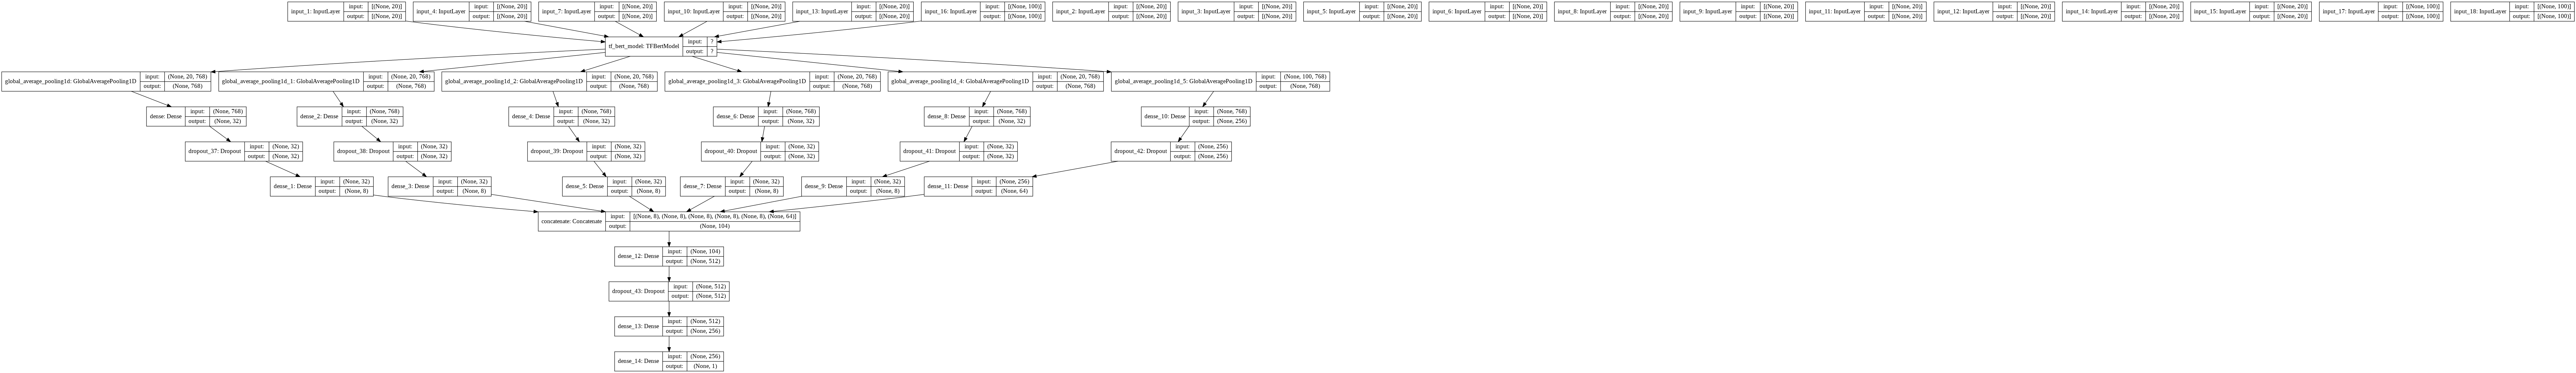

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='./Results/ColBERT_Task2_Base_model_plot.png', show_shapes=True, show_layer_names=True)

## 5. Training, validation and testing

Loops over the folds in gkf and trains each fold for 3 epochs --- with a learning rate of 3e-5 and batch_size of 6. A simple binary crossentropy is used as the objective-/loss-function. 

In [ ]:
# Evaluation Metrics
import sklearn

def print_evaluation_metrics(y_true, y_pred, label='', is_regression=True, label2=''):

    print('==================', label2)
    ### For regression
    if is_regression:
        print("Regression task returns: MSE")
        print('mean_absolute_error',label,':', sklearn.metrics.mean_absolute_error(y_true, y_pred))
        print('mean_squared_error',label,':', sklearn.metrics.mean_squared_error(y_true, y_pred))
        print('root mean_squared_error (RMSE) ',label,':', np.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred)) )
        print('r2 score',label,':', sklearn.metrics.r2_score(y_true, y_pred))
        #     print('max_error',label,':', sklearn.metrics.max_error(y_true, y_pred))
        return sklearn.metrics.mean_squared_error(y_true, y_pred)
    else:
        ### FOR Classification
#         print('balanced_accuracy_score',label,':', sklearn.metrics.balanced_accuracy_score(y_true, y_pred))
#         print('average_precision_score',label,':', sklearn.metrics.average_precision_score(y_true, y_pred))
#         print('balanced_accuracy_score',label,':', sklearn.metrics.balanced_accuracy_score(y_true, y_pred))
#         print('accuracy_score',label,':', sklearn.metrics.accuracy_score(y_true, y_pred))
        
        print("Classification returns: Acc")

        print('f1_score',label,':', sklearn.metrics.f1_score(y_true, y_pred))
        
        matrix = sklearn.metrics.confusion_matrix(y_true, y_pred)
        print(matrix)
        TP,TN,FP,FN = matrix[1][1],matrix[0][0],matrix[0][1],matrix[1][0]
        Accuracy = (TP+TN)/(TP+FP+FN+TN)
        Precision = TP/(TP+FP)
        Recall = TP/(TP+FN)
        F1 = 2*(Recall * Precision) / (Recall + Precision)
        print('Acc', Accuracy, 'Prec', Precision, 'Rec', Recall, 'F1',F1)

        return sklearn.metrics.accuracy_score(y_true, y_pred)

print_evaluation_metrics([1,0], [0.9,0.1], '', True)
print_evaluation_metrics([1,0], [1,1], '', False)

Regression task returns: MSE
mean_absolute_error  : 0.09999999999999999
mean_squared_error  : 0.009999999999999998
root mean_squared_error (RMSE)   : 0.09999999999999999
r2 score  : 0.96
Classification returns: Acc
f1_score  : 0.6666666666666666
[[0 1]
 [0 1]]
Acc 0.5 Prec 0.5 Rec 1.0 F1 0.6666666666666666


0.5

### Loss function selection
Regression problem between 0 and 1, so binary_crossentropy and mean_absolute_error seem good.

Here are the explanations: https://www.dlology.com/blog/how-to-choose-last-layer-activation-and-loss-function/

In [ ]:
training_epochs = 5

min_acc = 100
min_test = []

dev_preds = []
test_preds = []
best_model = False

for BS in [6]:
    LR = 1e-5
    print('>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>')
    print('LR=', LR)

    gkf = GroupKFold(n_splits=2).split(X=df_train.text, groups=df_train.text)

    for fold, (train_idx, valid_idx) in enumerate(gkf):

        if fold not in range(running_folds):
            continue

        train_inputs = [(inputs[i][:])[:training_sample_count] for i in range(len(inputs))]
        train_outputs = (outputs[:])[:training_sample_count]

        #train_inputs = [(inputs[i][train_idx])[:training_sample_count] for i in range(len(inputs))]
        #train_outputs = (outputs[train_idx])[:training_sample_count]

        #valid_inputs = [inputs[i][valid_idx] for i in range(len(inputs))]
        #valid_outputs = outputs[valid_idx]

        #print(len(train_idx), len(train_outputs))

        model = create_model()
        K.clear_session()
        optimizer = tf.keras.optimizers.Adam(learning_rate=LR)
        #model.compile(loss='binary_crossentropy', optimizer=optimizer)
        model.compile(loss=tf.keras.metrics.mean_squared_error, metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')],optimizer=optimizer)
        print('model compiled')
        
        model.fit(train_inputs, train_outputs, epochs=training_epochs, batch_size=BS, verbose=1,
#                 validation_split=0.2, 
#                  validation_data=(x_val, y_val)
                 )
        # model.save_weights(f'bert-{fold}.h5')
        #valid_preds.append(model.predict(valid_inputs))
        
        dev_preds.append(model.predict(dev_inputs))
                
        acc = print_evaluation_metrics(np.array(dev_outputs), np.array(dev_preds[-1]))

        if acc < min_acc:
            print('new acc >> ', acc)
            min_acc = acc
            best_model = model

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
LR= 1e-05
(None, 768)
model compiled
Epoch 1/5
1334/1334 [==============================] - 384s 219ms/step - loss: 0.3579 - rmse: 0.5703
Epoch 2/5
1334/1334 [==============================] - 291s 218ms/step - loss: 0.1038 - rmse: 0.3219
Epoch 3/5
1334/1334 [==============================] - 293s 219ms/step - loss: 0.0691 - rmse: 0.2629
Epoch 4/5
1334/1334 [==============================] - 289s 217ms/step - loss: 0.0645 - rmse: 0.2540
Epoch 5/5
1334/1334 [==============================] - 290s 217ms/step - loss: 0.0546 - rmse: 0.2336
Regression task returns: MSE
mean_absolute_error  : 0.3294048931524158
mean_squared_error  : 0.3272174211100251
root mean_squared_error (RMSE)   : 0.5720292135110104
r2 score  : 0.7689458145720117
new acc >>  0.3272174211100251


## Regression submission

In [ ]:
# check the dev set results
min_test = best_model.predict(dev_inputs)
df_dev['offense_rating_pred'] = min_test

print_evaluation_metrics(df_dev['offense_rating'], df_dev['offense_rating_pred'], '', True)
df_dev.head()

Regression task returns: MSE
mean_absolute_error  : 0.3294048931524158
mean_squared_error  : 0.3272174211100251
root mean_squared_error (RMSE)   : 0.5720292135110104
r2 score  : 0.7689458145720117


,id,text,is_humor,humor_rating,humor_controversy,offense_rating,offense_rating_pred
0,8001,What's the difference between a Bernie Sanders...,1,2.45,0.0,1.70,2.059433
1,8002,"Vodka, whisky, tequila. I'm calling the shots.",1,2.00,0.0,0.00,0.128105
2,8003,French people don't masturbate They Jacque off,1,2.95,0.0,1.15,2.005441
3,8004,A lot of Suicide bombers are Muslims - I don't...,1,1.38,0.0,3.75,3.406773
4,8005,What happens when you fingerbang a gypsy on he...,1,2.70,1.0,2.25,2.471478


In [ ]:
df_dev[df_dev['offense_rating_pred']-df_dev['offense_rating']>1]

,id,text,is_humor,humor_rating,humor_controversy,offense_rating,offense_rating_pred
62,8063,What do you call a Mexican bodybuilder without...,1,2.65,0.0,0.85,2.288731
82,8083,I don't understand how Elvis got so fat He ate...,1,2.30,1.0,0.20,1.211578
157,8158,So the Substack Top 25 Paid is v. white and v....,0,NaN,NaN,0.25,1.491815
233,8234,How many immature people does it take to chang...,1,2.32,1.0,0.70,1.835389
252,8253,What do you get if a post office burns down? B...,1,1.70,0.0,0.30,3.257627
339,8340,What did the lifeguard say to the drowning hip...,1,2.35,0.0,0.20,1.503898
343,8344,"Sorry about your street cred, black guys named...",1,1.59,0.0,1.65,2.784920
371,8372,I'm as wary as most people on here about the p...,0,NaN,NaN,0.30,1.861358
433,8434,Police were called to a daycare centre today. ...,1,2.95,0.0,0.00,1.297488
442,8443,Why does a milking stool have only 3 legs? Bec...,1,2.45,0.0,0.00,1.101460


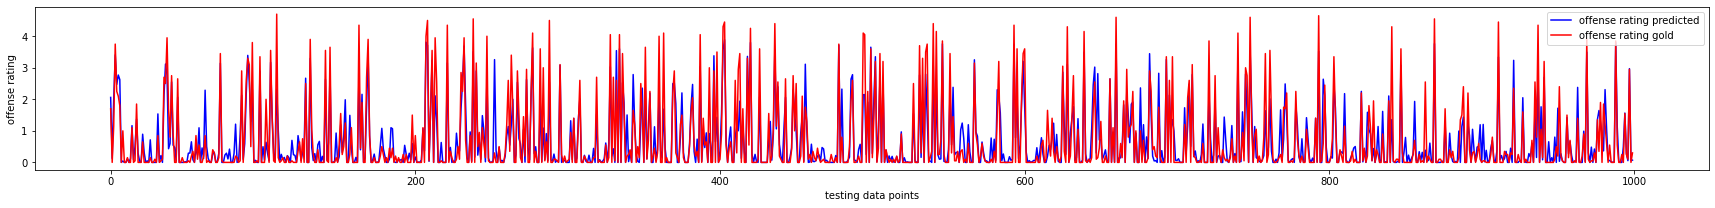

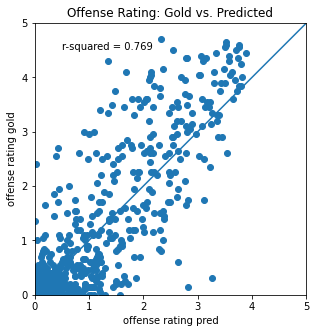

In [ ]:
import matplotlib.pyplot as plt

df_sub = df_dev

fig, axs = plt.subplots(1,1, figsize=(30,3))

x = np.arange(len(df_sub))
axs.plot(x,df_sub['offense_rating_pred'],color ='blue', label='offense rating predicted')
axs.plot(x,df_sub['offense_rating'],color ='red', label='offense rating gold')
axs.set_xlabel('testing data points')
axs.set_ylabel('offense rating')
axs.legend(loc='upper right')

plt.show()

fig, axs = plt.subplots(1,1, figsize=(5,5))
x = np.linspace(0,5,50)
axs.scatter(df_sub['offense_rating_pred'],df_sub['offense_rating'])
axs.set_xlim(0,5)
axs.set_ylim(0,5)
axs.set_xlabel('offense rating pred')
axs.set_ylabel('offense rating gold')
axs.set_aspect('equal')
axs.plot(x,x)

axs.annotate("r-squared = {:.3f}".format(sklearn.metrics.r2_score(df_sub['offense_rating'], df_sub['offense_rating_pred'])), (0.5, 4.5))
axs.set_title('Offense Rating: Gold vs. Predicted')

plt.show()

### Get Test Set Results for Submission

In [ ]:
min_test = best_model.predict(test_inputs)
df_test['offense_rating'] = min_test
print(df_test.head())

# drop the text column for submission
df_sub = df_test.drop('text',axis = 1)
print(df_sub.head())

df_sub.to_csv('./Results/ColBERT_BaseUncased_Task2.csv', index=False)

     id                                               text  offense_rating
0  9001  Finding out your ex got fat is like finding 20...        1.009341
1  9002  For Brockmann, stereotypes imperil national se...        0.720423
2  9003  A girl runs up to her mother with a pile of cr...        0.834102
3  9004  gotta wonder if baseball still would've been c...        0.468363
4  9005  When you're dreading getting in the shower cuz...        0.271404
     id  offense_rating
0  9001        1.009341
1  9002        0.720423
2  9003        0.834102
3  9004        0.468363
4  9005        0.271404
